## Loading IAM Lines dataset from hugging face

In [6]:
from datasets import load_dataset

ds = load_dataset("AlhitawiMohammed22/En_IAM_lines")

d:\Hackathons\MLX\code\venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\madhu\.cache\huggingface\hub\datasets--AlhitawiMohammed22--En_IAM_lines. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|██████████| 13353/13353 [00:00<00:00, 1223892.43 examples/s]


In [7]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['file_name', 'text'],
        num_rows: 13353
    })
})


### Checking dataset structure

In [8]:
print(ds['train'][0])  
print(ds['train'].column_names)
print(f"Total samples: {len(ds['train'])}")


{'file_name': 'a01-000u-00.png', 'text': 'A MOVE to stop Mr. Gaitskell from'}
['file_name', 'text']
Total samples: 13353


In [33]:
file_names = ds['train']['file_name']
texts = ds['train']['text']

print(f"Sample Image: {file_names[20]}")
print(f"Corresponding Text: {texts[20]}")


Sample Image: a01-003-07.png
Corresponding Text: that the House of Lords should be abolished


### Checking image and text pairs

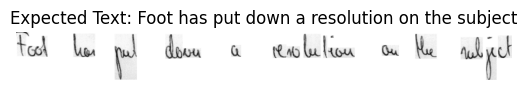

In [14]:
import os
import cv2
import matplotlib.pyplot as plt
from datasets import load_dataset

image_folder = "D:\\Hackathons\\MLX\\images\\images"  

# Function to check and display images with their expected text
def display_sample(index):
    """Display an image and its corresponding text label."""
    sample = ds['train'][index] 
    image_path = os.path.join(image_folder, sample['file_name'])
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(image, cmap='gray')
    plt.title(f"Expected Text: {sample['text']}")
    plt.axis("off")
    plt.show()

display_sample(10)


### Pre-processing Image

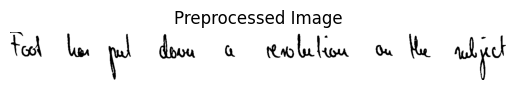

In [25]:
def preprocess_image(image_path):
    """Preprocess image for better OCR recognition."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  
    image = cv2.GaussianBlur(image, (3, 3), 0) 
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]  
    return image

# Test preprocessing on a sample image
sample_image_path = os.path.join(image_folder, ds['train'][10]['file_name'])
processed_img = preprocess_image(sample_image_path)

plt.imshow(processed_img, cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")
plt.show()


### Loading pre-trained model

In [19]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [20]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decode

### Function to pre process and extract text

In [ ]:
def preprocess_image(image):    
    image = cv2.GaussianBlur(image, (3, 3), 0)  
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 11, 2)  
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 
    processed_image = Image.fromarray(image_rgb)
    return processed_image

def extract_text_trocr_preprocessed(image):
    """Extract text using TrOCR on a preprocessed image."""
    preprocessed_img = preprocess_image(image) 
    pixel_values = processor(images=preprocessed_img, return_tensors="pt").pixel_values

    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    extracted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return extracted_text


In [ ]:
from textblob import TextBlob

def correct_text(image):
    extracted_text = extract_text_trocr_preprocessed(image)
    corrected_text = str(TextBlob(extracted_text).correct())
    return corrected_text


In [38]:
import evaluate 
from tqdm import tqdm  

cer_metric = evaluate.load("cer")  
wer_metric = evaluate.load("wer")  

num_samples = 100

ground_truths = []
predictions = []

for i in tqdm(range(num_samples), desc="Evaluating Accuracy"):
    img_path = os.path.join(image_folder, ds['train'][i]['file_name'])
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
    ground_truth = ds['train'][i]['text']  
    predicted_text = extract_text_trocr_preprocessed(img_path)  

    ground_truths.append(ground_truth)
    predictions.append(predicted_text)

# Compute Character Error Rate (CER) and Word Error Rate (WER)
cer_score = cer_metric.compute(predictions=predictions, references=ground_truths)
wer_score = wer_metric.compute(predictions=predictions, references=ground_truths)

print(f"Character Error Rate (CER): {cer_score:.4f}")
print(f"Word Error Rate (WER): {wer_score:.4f}")


Evaluating Accuracy: 100%|██████████| 100/100 [04:09<00:00,  2.49s/it]

Character Error Rate (CER): 0.0815
Word Error Rate (WER): 0.1486
